# Visualize benchmarking results

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.transforms as transforms

sns.set_theme(context='paper', style='ticks', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)

In [2]:
# path where figures are going to be saved
FIG_PATH = 'plots'

------------

## Read results

In [3]:
### Simulation of null/differences###
null_sim_results = pd.read_csv("results/benchmark/simulation_results_null.tsv", sep="\t")
difs_sim_results = pd.read_csv("results/benchmark/simulation_results_diff.tsv", sep="\t")

### Benchmarking bootstrapping ###
benchmark_hit_rates = pd.read_csv('results/benchmark/benchmark_hitrates.tsv', sep='\t')
benchmark_stats = pd.read_csv('results/benchmark/benchmark_stats.tsv', sep='\t')
best_auroc = pd.read_csv('results/benchmark/benchmark_best_auroc.tsv', sep='\t')

In [4]:
rename_clusters = {'Cardiomyocytes': "Changed1", 'Fibroblast': "Changed2", 'Smooth muscle cells': "Changed3", 
                   'Endothelial cells': "Unchanged1", "Epicardial cells": "Unchanged2", 
                   "Immune cells": "Unchanged3", "Neurons": "Unchanged4"}
difs_sim_results["clusters"] = difs_sim_results["clusters"].map(rename_clusters)

In [5]:
# Calculate hitrate for null simulation
null_sim_hitrates = null_sim_results.groupby(["run", "clusters", "n_reps", "replicated", "transform"])["correct"].mean().reset_index()
null_sim_hitrates = null_sim_hitrates.rename(columns={"correct": "hit_rate"})
null_sim_hitrates["hit_rate"] *= 100
null_sim_hitrates["dataset"] = "null"

null_sim_hitrates_mean = null_sim_hitrates.groupby(["n_reps", "replicated", "transform"])["hit_rate"].mean().reset_index()
null_sim_hitrates_mean = null_sim_hitrates_mean.rename(columns={"hit_rate": "mean_hit_rate"})

In [6]:
# Calculate hitrate for true differences
difs_sim_hitrates = difs_sim_results.groupby(["run", "clusters", "n_reps", "replicated", "transform"])["correct"].mean().reset_index()
difs_sim_hitrates = difs_sim_hitrates.rename(columns={"correct": "hit_rate"})
difs_sim_hitrates["hit_rate"] *= 100
difs_sim_hitrates["dataset"] = "difs"

difs_sim_hitrates_mean = difs_sim_hitrates.groupby(["n_reps", "replicated", "transform"])["hit_rate"].mean().reset_index()
difs_sim_hitrates_mean = difs_sim_hitrates_mean.rename(columns={"hit_rate": "mean_hit_rate"})

------

## Plots

### Hit rates

In [7]:
def join_xticks(fig, ax, label, dx=0.4):
    """ Add horizontal bar to join x axis labels in heatmap """
    
    ticks = ax.xaxis.get_major_ticks()
    ticks = [tick for tick in ticks if tick.label1._text == label]
    
    # Convert from display -> converted coordinates
    trans_y = ax.transData
    trans_y_inv = trans_y.inverted()                                      
    tick_bboxes = [tick.tick1line.get_window_extent().transformed(trans_y_inv) for tick in ticks] 
    bbox_trans = tick_bboxes[0]
    
    #Plot horizontal line between ticks
    trans = transforms.blended_transform_factory(ax.transData, trans_y)
    tick_x = [tick._loc for tick in ticks]  # data coordinates
    tick_y = [bbox_trans.y0 + (bbox_trans.y0-bbox_trans.y1)/2]*2  #converted coordinates + half length
    ax.plot(tick_x, tick_y, color="black", lw=0.8, transform=trans, clip_on=False)

    # Move labels using transform
    dx = 0.4
    offset = transforms.ScaledTranslation(dx, 0, fig.dpi_scale_trans)
    ticks[0].label1.set_transform(ticks[0].label1.get_transform() + offset)
    _ = [tick.label1.set_visible(False) for tick in ticks[1:]]

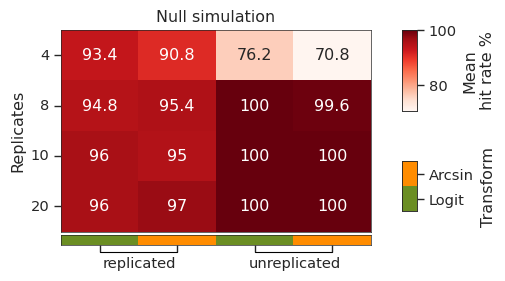

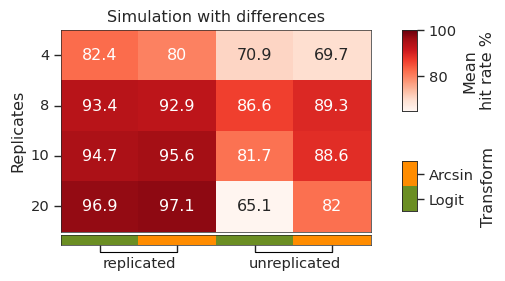

In [8]:
simulations = {'Null simulation': {"data": null_sim_hitrates_mean,
                                   "save": "null_simulation_heatmap.pdf"},
               'Simulation with differences': {"data": difs_sim_hitrates_mean,
                                               "save": "difs_simulation_heatmap.pdf"}}

for sim in simulations:

    # Prepare data
    data = simulations[sim]["data"].copy()
    data["method"] = data["replicated"] + "_" + data["transform"]
    data = data.set_index('n_reps')
    data = data.pivot(columns=['method'], values="mean_hit_rate")
    data = data[["rep_logit", "rep_arcsin", "norep_logit", "norep_arcsin"]]  #ensure order

    # Initialize plotting grid
    fig, axarr = plt.subplots(2,1, figsize=(4, 2.8), height_ratios=[0.95,0.05])
    axarr = axarr.flatten()
    plt.subplots_adjust(wspace=0.15, hspace=0.03)

    ############### Colorbars ################

    #Create extra axes for colorbars
    transform_colors = ["olivedrab", "darkorange"]
    ax = axarr[0]

    transform_cax = inset_axes(ax,
                                 width="5%", height="25%",
                                 loc='lower left',
                                 bbox_to_anchor=(1.1, 0.1, 1, 1),
                                 bbox_transform=ax.transAxes, borderpad=0)
    transform_cax.set_frame_on(True)


    pvalue_cax = inset_axes(ax,
                            width="5%", height="40%",
                            loc='lower left',
                            bbox_to_anchor=(1.1, 0.6, 1, 1),
                            bbox_transform=ax.transAxes, borderpad=0)
    pvalue_cax.set_frame_on(True)


    # First row
    ax = axarr[0]
    sns.heatmap(data, 
                annot=True, fmt='0.3g',
                ax=ax, cmap='Reds', cbar_ax=pvalue_cax, xticklabels=False, 
                cbar_kws={'label': 'Mean\nhit rate %'}, vmax=100)
    ax.set_ylabel("Replicates")

    # Second row
    ax = axarr[1]
    sns.heatmap([[0,1,0,1]], ax=ax, cbar_ax=transform_cax, 
                yticklabels=False, 
                cmap=transform_colors)
    ax.set_ylabel("")

    #Transformation to categorical
    colorbar = axarr[1].collections[0].colorbar
    colorbar.set_label("Transform", labelpad=5)
    colorbar.set_ticks([0.25,0.75])
    colorbar.set_ticklabels(["Logit", "Arcsin"])

    #xticks
    ax.set_xticks(ax.get_xticks(), ["replicated",  "replicated", "unreplicated", "unreplicated"], 
                  rotation=0, ha='center', rotation_mode='default')
    join_xticks(fig, ax, "replicated", 0.4)
    join_xticks(fig, ax, "unreplicated", 0.4)


    ############ Final adjustments ##############

    #Titles
    axarr[0].set_title(f"{sim}")

    ### Set format of labels
    for ax in axarr:
        ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=0, ha='right')
        ax.set_xlabel("")

        # Drawing the frame
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.5)

    #Border around cbars
    for cax in [pvalue_cax, transform_cax]:
        for _, spine in cax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.5)

    # Save final figure
    save = simulations[sim]["save"]
    plt.savefig(f"{FIG_PATH}/{save}", bbox_inches="tight")

### Correct assignments per cluster

In [9]:
hitrates = pd.concat([null_sim_hitrates, difs_sim_hitrates])

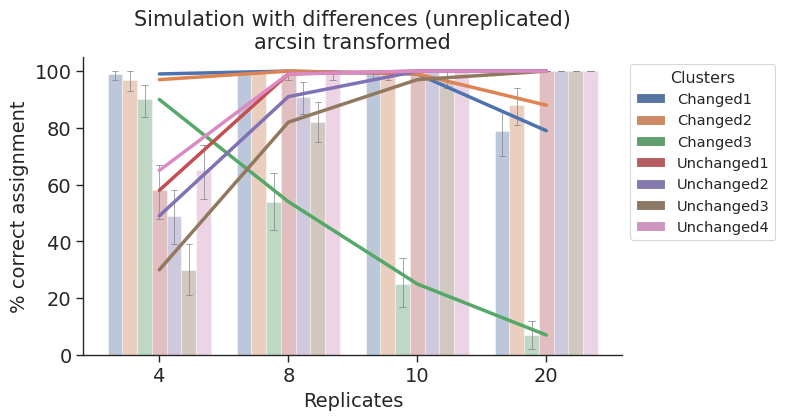

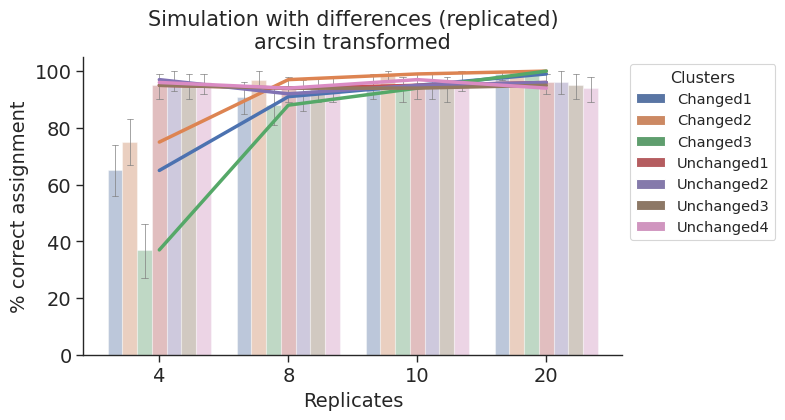

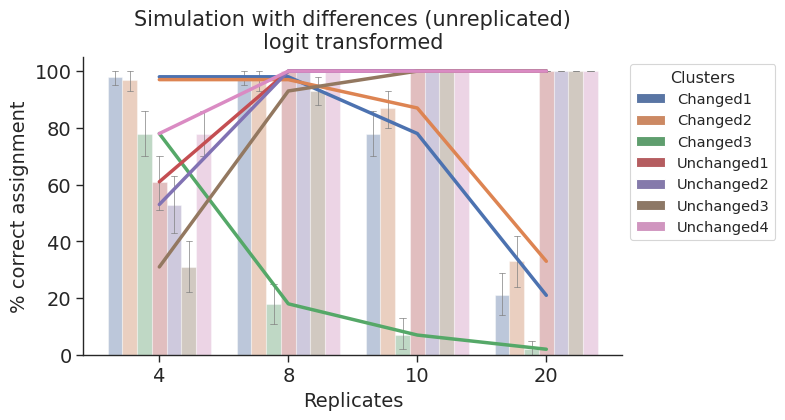

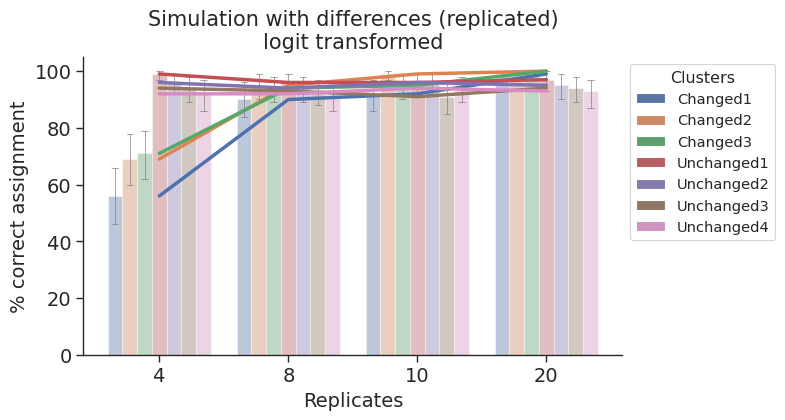

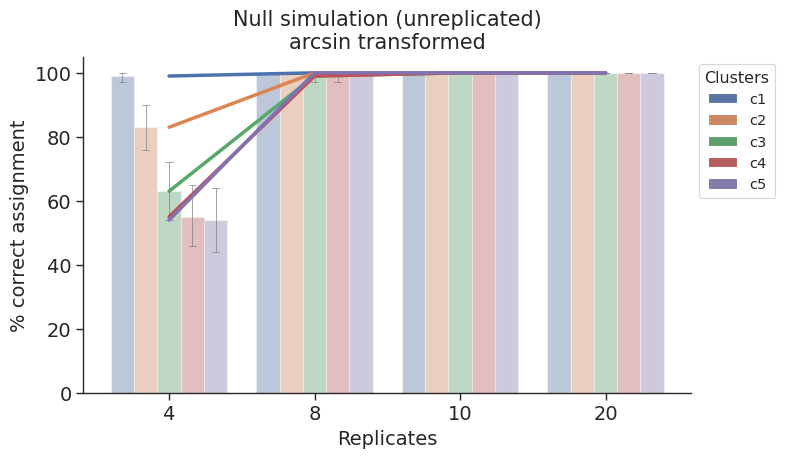

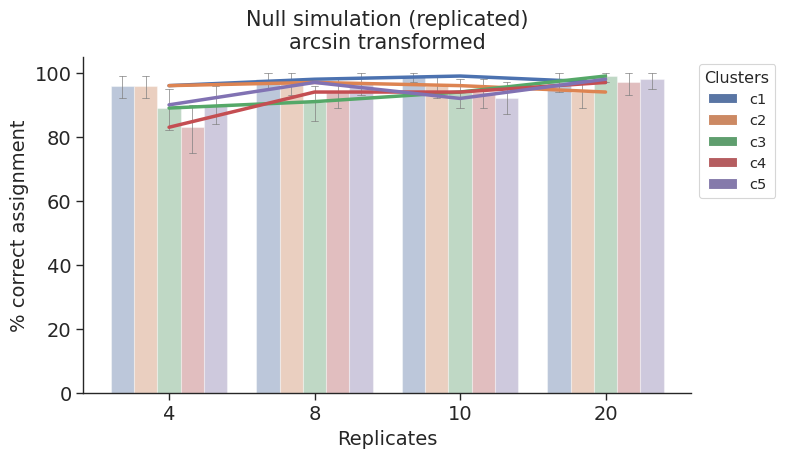

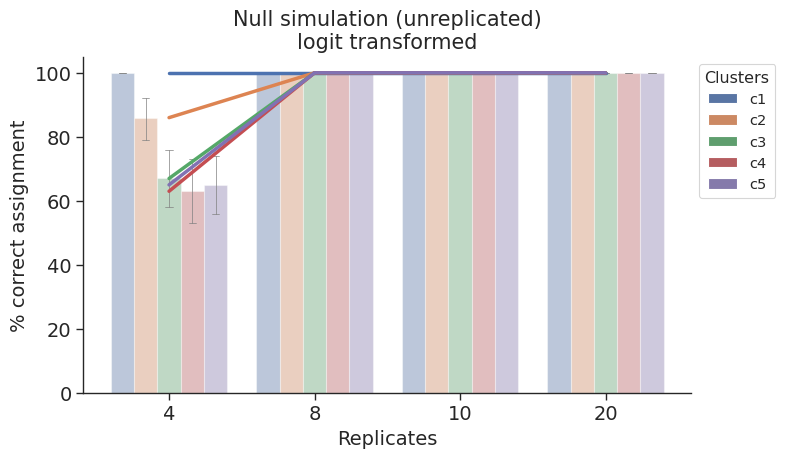

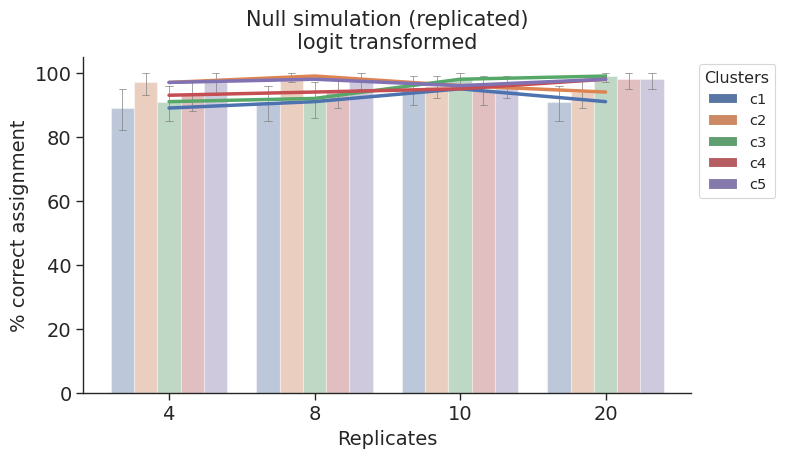

In [10]:
import warnings
warnings.filterwarnings("ignore")

for idx, data in hitrates.groupby(["dataset", "transform", "replicated"]):
    
    dataset, transform, replicated = idx
    
    data["n_reps"] = data["n_reps"].astype(str)
    data["transform"] = data["transform"].astype(str)

    # Prepare plot
    fig, ax = plt.subplots(1, figsize=(8, 8), tight_layout=True)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_aspect(0.022)

    # Plot hit rate as barplot
    sns.barplot(data=data, x='n_reps', y='hit_rate', hue='clusters', alpha=0.4, ax=ax,
                capsize=.05, errwidth=0.5, errcolor=".5")
    legend = ax.legend(loc="upper right")
    [legend.legend_handles[i].set_alpha(1) for i in range(len(legend.legend_handles))]

    # plot hit rate as lineplot
    sns.lineplot(data=data, x='n_reps', y='hit_rate', hue='clusters', ax=ax, linewidth=2.5, legend=False, errorbar=None)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title="Clusters")
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    ax.set_xlabel("Replicates", size=14)
    ax.set_ylabel('% correct assignment', size=14)
    
    title = "Simulation with differences" if dataset == "difs" else "Null simulation" 
    title += f" ({replicated.replace('rep', 'replicated').replace('no', 'un')})"
    title += f"\n{transform} transformed"
    ax.set_title(title, fontsize=15)

    #### Finalize ####
    filename = f"{dataset}_simulation_{replicated}_{transform}.pdf"
    plt.savefig(f'{FIG_PATH}/{filename}', dpi=300, bbox_inches='tight')

    plt.show()

-------------

## Plot overview per rep combination

In [11]:
# Calculate -log10(pvalue)
difs_sim_results["p_values_joined"] = difs_sim_results["adjusted_p_values"].fillna(difs_sim_results["p_values"])
difs_sim_results["-log10(p-value)"] = -np.log10(difs_sim_results["p_values_joined"])

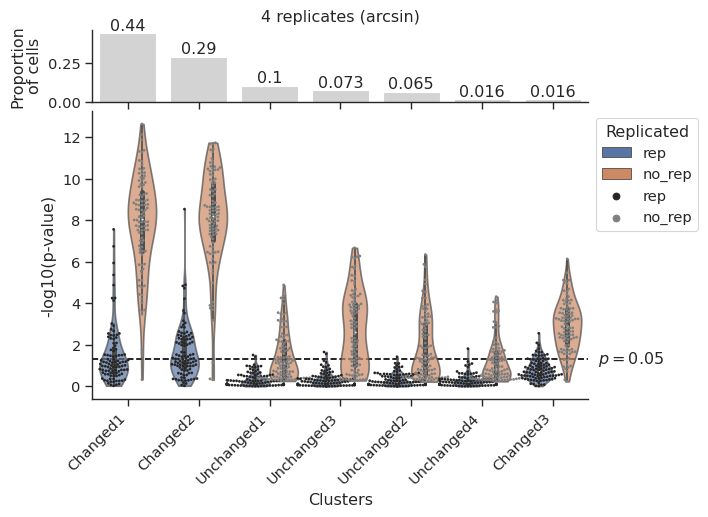

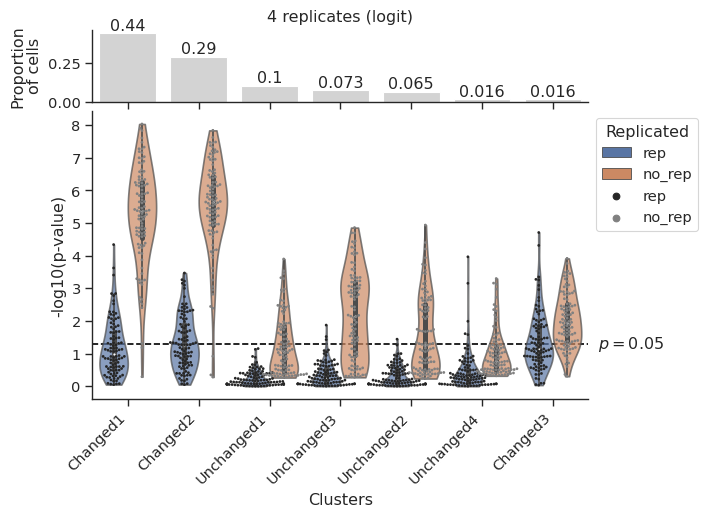

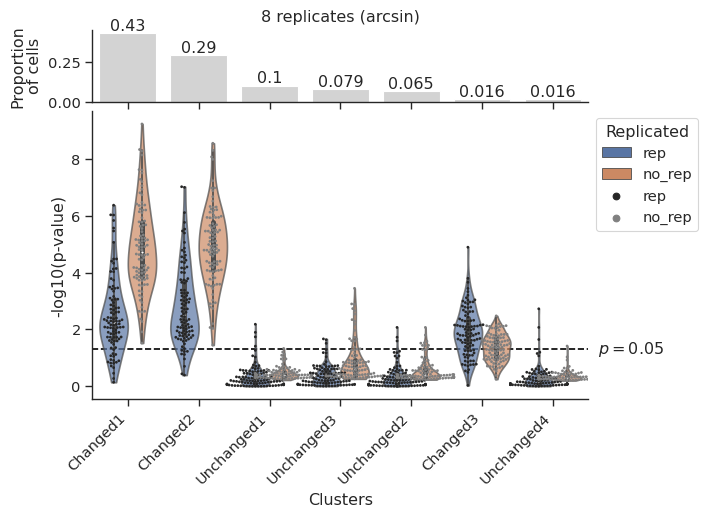

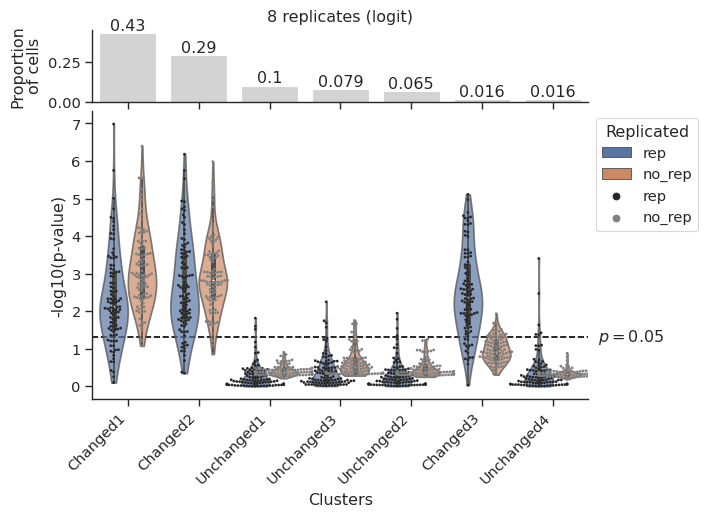

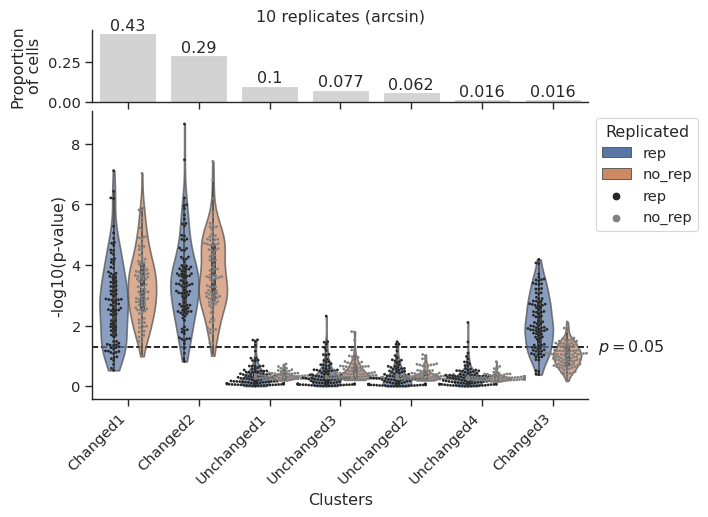

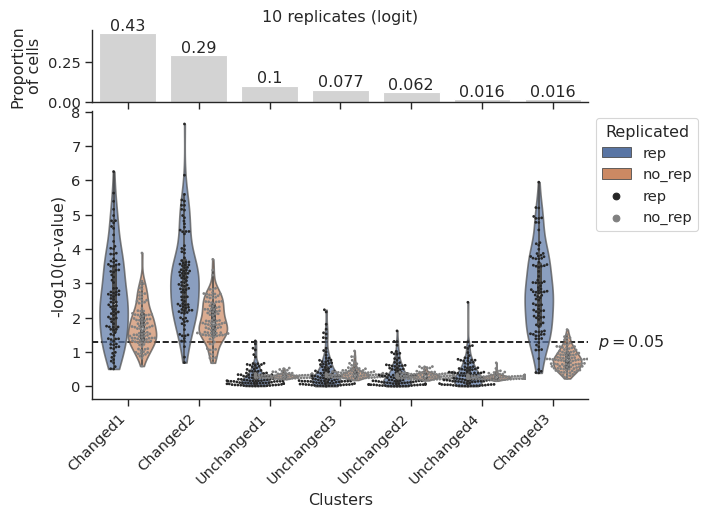

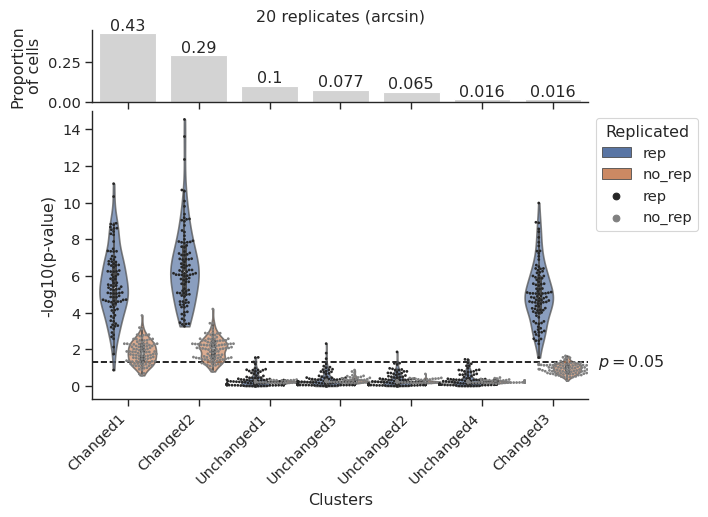

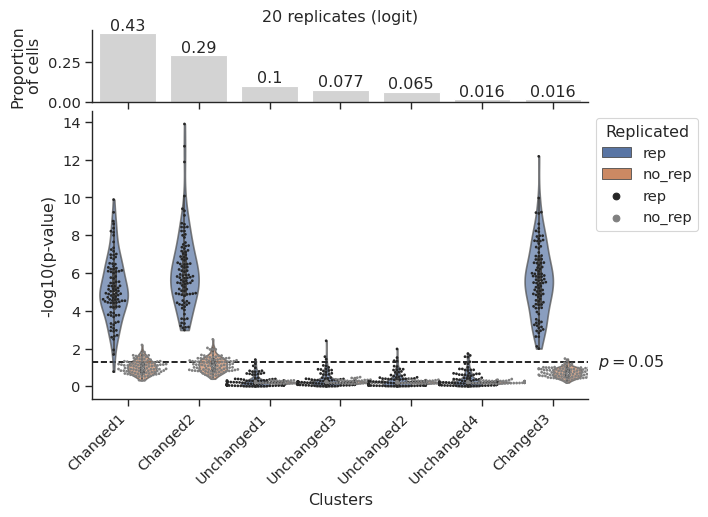

In [12]:
import warnings
warnings.filterwarnings("ignore")

for (reps, transform), table in difs_sim_results.groupby(["n_reps", "transform"]):

    table["Replicated"] = table["replicated"].replace("norep", "no_rep")
    
    # Prepare data
    mean_props = table[table["Replicated"] == "rep"].groupby("clusters")["baseline_props"].mean().sort_values(ascending=False)
    index_name = mean_props.index.tolist()
    
    #### Prepare plot ####
    fig, axarr = plt.subplots(2, sharex=True, height_ratios=[0.2,0.8])
    plt.subplots_adjust(hspace=0.05)
    
    for ax in axarr:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    ax = axarr[0]
    
    # Add title to plot
    title = f"{reps} replicates ({transform})"
    ax.set_title(title)

    # Add proportion on top
    ax = axarr[0]
    sns.barplot(x=index_name, y=mean_props, ax=ax, color="lightgrey")
    ax.set_xlabel("")
    ax.set_ylabel("Proportion\nof cells")
    ax.bar_label(ax.containers[0], fmt='%.2g')

    # Plot results of simulated run
    ax = axarr[1]
    sns.violinplot(table, x="clusters", y="-log10(p-value)", 
                    cut=0, scale="width", ax=ax, hue="Replicated", order=index_name)
    for violin in ax.collections[::2]:
        violin.set_alpha(0.7)
    ax.set_xlabel("Clusters")
        
    # Remove duplicates entries in legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[-2:], labels[-2:], loc="upper left", bbox_to_anchor=(1.05,1))
    
    #Plot data points on top of violins
    sns.swarmplot(table, x="clusters", y="-log10(p-value)", color="grey", ax=ax,
                  hue="Replicated", dodge=True, size=2, order=index_name)    
    
    # Plot threshold line
    pvalue_threshold = -np.log10(0.05)
    ax.axhline(pvalue_threshold, zorder=0, color="black", ls="--")
    ax.text(ax.get_xlim()[1], pvalue_threshold, "  $\it{p=0.05}$", va="center")
    
    # Set xticklabels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    # Set limit on y axis
    ylim = ax.get_ylim()
    thresh = -np.log10(10**-15)
    if ylim[1] > thresh:
        ax.set_ylim(ylim[0], thresh)
    
    filename = f"difs_{reps}reps_{transform}_bootstrap_comparison.pdf"
    plt.savefig(f"plots/{filename}", dpi=300, bbox_inches="tight")
    plt.show()

-------------------------

## Benchmarking bootstrapping with increasing counts

### sensitivity vs false positive rate

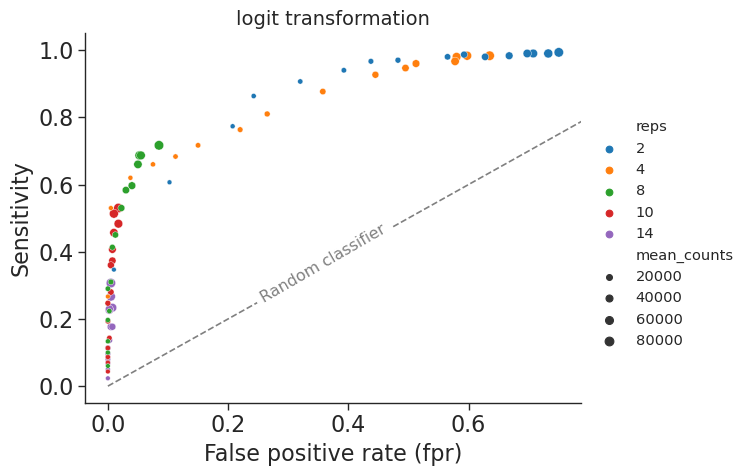

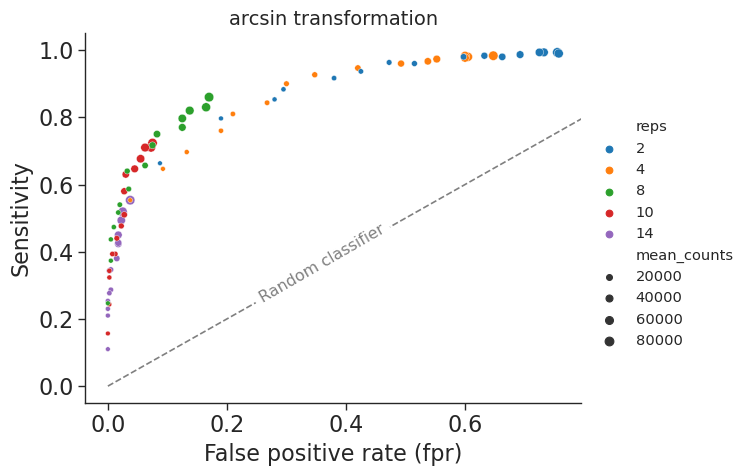

In [13]:
benchmark_stats_logit = benchmark_stats[benchmark_stats['trans'] == 'logit']
benchmark_stats_arcsin = benchmark_stats[benchmark_stats['trans'] == 'arcsin']

stats_data = {'logit': benchmark_stats_logit, 'arcsin': benchmark_stats_arcsin}

for trans in stats_data:

    data = stats_data[trans].sort_values("mean_counts", ascending=False)
    
    
    
    ax = sns.scatterplot(data=data, 
                         x='fpr', y='sensitivity', 
                         hue='reps', palette='tab10', size="mean_counts")

    ax.set_ylabel('Sensitivity', fontsize=16)
    ax.set_xlabel('False positive rate (fpr)', fontsize=16)
    ax.set_title(f"{trans} transformation", fontsize=14)
    
    # plot diagonal line w/text
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot([0,1], [0,1], color="grey", linestyle="--")
    ax.set_xlim(xlim)
    rot = 30
    ax.text(0.25, 0.25, "Random classifier", color="grey", rotation=rot, backgroundcolor="white")

    ax.spines[['right', 'top']].set_visible(False)
    plt.tick_params(axis='both', which='major', labelsize=16)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.8), frameon=False)
    
    plt.savefig(f'{FIG_PATH}/benchmark_sensitivity_fpr_{trans}.pdf', dpi=300, bbox_inches='tight')
    
    plt.show()

### Mean counts vs auroc

In [14]:
# extract number of reps with best auroc per mean counts
best_reps = best_auroc.drop_duplicates(['reps'], keep='last')['mean_counts'].to_list()
n_reps = best_auroc.drop_duplicates(['reps'], keep='last')['reps'].to_list()

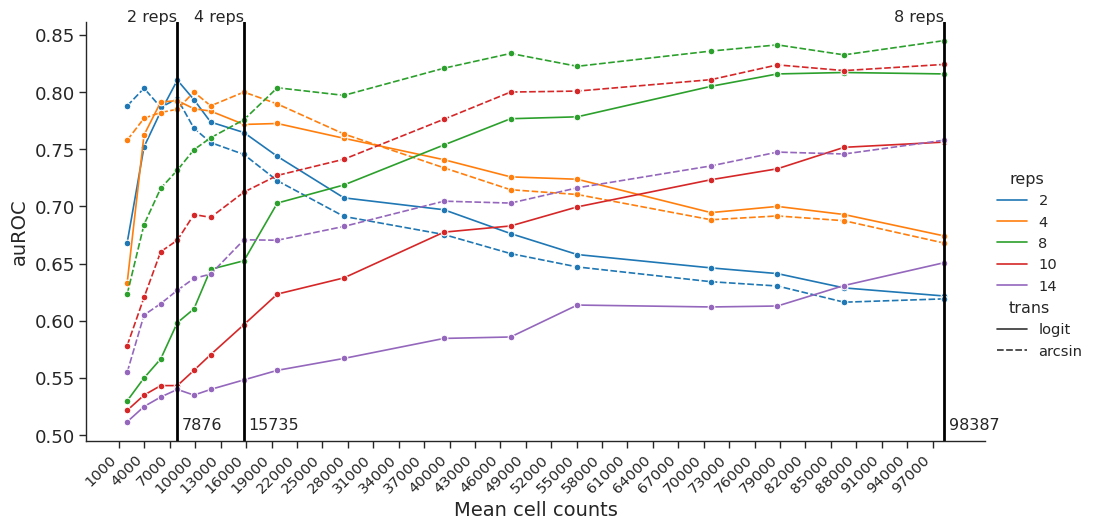

In [15]:
ticks = np.arange(1000, 100000, 3000)
x_labels = [str(label) for label in ticks]

plot_3 = sns.relplot(data=benchmark_stats, x='mean_counts', y='auroc', kind='line', errorbar=None,
                     hue='reps', aspect=2, marker='o', palette='tab10', style='trans')

for ax in plot_3.axes.flatten():
    ax.set_xticks(ticks, x_labels, rotation=90, ha='center')
    ax.set(xlabel='Mean counts', ylabel='auroc')

ax.set_ylabel('auROC', fontsize=14)
ax.set_xlabel('Mean cell counts', fontsize=14)
#ax.set_title("Mean cell counts vs Area under the roc curve (auroc)", fontsize=14)

plt.tick_params(axis='y', which='major', labelsize=13)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# plot ranges of best number of replicates
for i in range(len(best_reps)):
    ax.axvline(best_reps[i], color='black', linewidth=2)
    ax.text(best_reps[i], ax.get_ylim()[1], f'{n_reps[i]} reps', ha='right')
    ax.text(best_reps[i]+500, ax.get_ylim()[0]+0.01, f'{int(best_reps[i])}', ha='left')
    
    
plt.savefig(f'{FIG_PATH}/benchmark_mean_counts_auroc.pdf', dpi=300, bbox_inches='tight')

plt.show()

----------